# COMP5495 Robot Learning - Project part 2

Andrea Pierré & Jonathan Eisenbies

## Initialization

In [1]:
from pathlib import Path
import ipywidgets as widgets
import h5py
import numpy as np
from movement_primitives.promp import ProMP
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import make_splrep
from tqdm.auto import tqdm

In [2]:
# %matplotlib ipympl

## Select the data

In [3]:
data_path = Path("..")
data_path.exists()

True

In [4]:
demos_filepaths = list(data_path.glob("**/demos.h5"))
demos_filepaths

[PosixPath('../Door-Opening-v1/demos.h5')]

In [5]:
selection_widget = widgets.SelectMultiple(
    options=demos_filepaths,
    value=[],
    rows=10,
    description="Data files",
    disabled=False,
    layout=widgets.Layout(width="90%"),
)
display(selection_widget)

SelectMultiple(description='Data files', layout=Layout(width='90%'), options=(PosixPath('../Door-Opening-v1/de…

In [11]:
selected_files = selection_widget.value
selected_files

(PosixPath('../Door-Opening-v1/demos.h5'),)

## Process demonstrations

In [12]:
for filename in selected_files:
    if filename != "traj.h5":
        print(f"Processing: {filename}")

        with h5py.File(filename, "r") as fid:
            num_demos = len(list(fid.keys()))
            timesteps = fid["demo1"]["timestamps"].shape[0]
            xmlFile = fid["demo1"].attrs["xmlmodel"]

            stateSize = fid["demo1"]["states"].shape[1]
            actionSize = fid["demo1"]["actions"].shape[1]
            T = np.zeros([num_demos, timesteps])
            Y = np.zeros([num_demos, timesteps, stateSize])
            Actions = np.zeros([num_demos, timesteps, actionSize])

            for idx in range(num_demos):
                currentDemo = idx + 1
                fileTimestamps = fid[f"demo{currentDemo}"]["timestamps"]
                T[idx] = fileTimestamps

                fileStates = fid[f"demo{currentDemo}"]["states"]
                fileActions = fid[f"demo{currentDemo}"]["actions"]

                for jdx in range(fileStates.shape[0]):
                    Y[idx][jdx] = fileStates[jdx]
                    Actions[idx][jdx] = fileActions[jdx]

                # fileTime = fileStates[0]
                # fileQPOS = fileStates[:, 1:27]
                # fileQVEL = fileStates[27:]

Processing: ../Door-Opening-v1/demos.h5


In [13]:
# fig = plt.figure(figsize=(10, 5))

# ax1 = fig.add_subplot(111, projection="3d")
# for x in range(num_demos):
#     ax1.plot(T[x], Y[x, :, 1], Y[x, :, 2], Y[x, :, 3], label="Demo %g" % (x + 1))

# ax1.plot(T[0], Y_mean[:, 0], Y_mean[:, 1], Y_mean[:, 2], label="ProMP Mean Trajectory")
# ax1.legend(loc="best")
# ax1.set_xlabel("x")
# ax1.set_ylabel("y")
# ax1.set_zlabel("z")
# ax1.set_title("Demo Trajectories Compared to ProMP Mean Trajectory")
# plt.show()

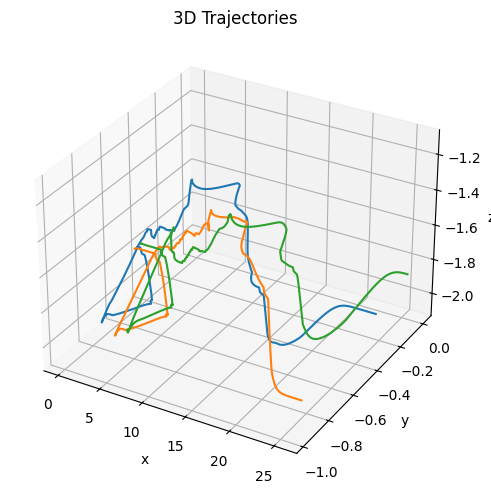

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
cmap = mpl.colormaps.get("tab10").colors

for d_i in range(num_demos):
    ax.plot(
        T[d_i],
        Y[d_i, :, 1],
        Y[d_i, :, 2],
        Y[d_i, :, 3],
        label=f"Demo {d_i + 1}",
        color=cmap[d_i],
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
ax.set_title("3D Trajectories")
plt.show()

In [15]:
# fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 7.5), layout="constrained")
# for x in range(num_demos):
#     axs[0][0].plot(T[x], Y[x, :, 1], label="Demo %g" % (x + 1))
#     axs[0][0].set_title("x")
#     axs[0][1].plot(T[x], Y[x, :, 2], label="Demo %g" % (x + 1))
#     axs[0][1].set_title("y")
#     axs[1][0].plot(T[x], Y[x, :, 3], label="Demo %g" % (x + 1))
#     axs[1][0].set_title("z")

# axs[0][0].plot(T[0], Y_mean[:, 0], label="ProMP Mean Trajectory")
# axs[0][1].plot(T[0], Y_mean[:, 1], label="ProMP Mean Trajectory")
# axs[1][0].plot(T[0], Y_mean[:, 2], label="ProMP Mean Trajectory")
# axs[0][0].legend(loc="best")
# axs[0][1].legend(loc="best")
# axs[1][0].legend(loc="best")
# plt.show()

## Smoothing

In [16]:
nb_points = 200
smoothing = 0.001
Y_smooth = np.zeros([num_demos, nb_points, stateSize])
total_sec_interp = np.linspace(T[0, 0], T[-1, -1], nb_points)
for d_i in tqdm(range(num_demos)):
    for s_i in tqdm(range(stateSize), leave=False):
        # Y_smooth[d_i, :, 0] = make_splrep(T[:, 0], Y[d_i, :, 0], s=smoothing)(total_sec_interp)
        # Y_smooth[d_i, :, 1] =  make_splrep(T[:, 0], Y[d_i, :, 1], s=smoothing)(total_sec_interp)
        # Y_smooth[d_i, :, 2] =  make_splrep(T[:, 0], Y[d_i, :, 2], s=smoothing)(total_sec_interp)
        Y_smooth[d_i, :, s_i] = make_splrep(T[0, :], Y[d_i, :, s_i], s=smoothing)(
            total_sec_interp
        )

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

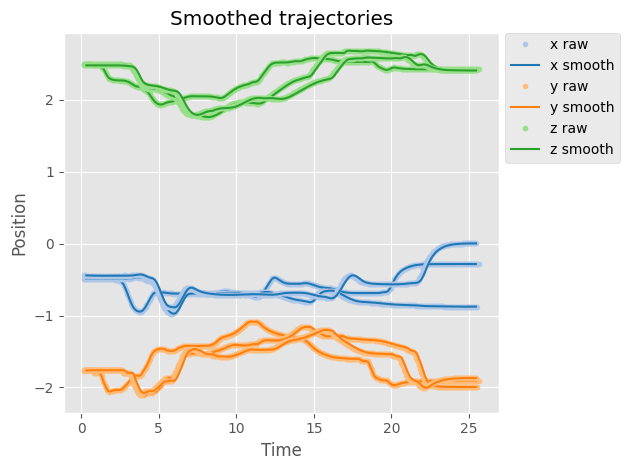

In [17]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab20").colors

    for d_i in range(num_demos):
        if d_i == 0:
            ax.plot(T[d_i], Y[d_i, :, 1], ".", label="x raw", color=cmap[1])
            ax.plot(
                total_sec_interp,
                Y_smooth[d_i, :, 1],
                "-",
                label="x smooth",
                color=cmap[0],
            )
            ax.plot(T[d_i], Y[d_i, :, 2], ".", label="y raw", color=cmap[3])
            ax.plot(
                total_sec_interp,
                Y_smooth[d_i, :, 2],
                "-",
                label="y smooth",
                color=cmap[2],
            )
            ax.plot(T[d_i], Y[d_i, :, 3], ".", label="z raw", color=cmap[5])
            ax.plot(
                total_sec_interp,
                Y_smooth[d_i, :, 3],
                "-",
                label="z smooth",
                color=cmap[4],
            )
        else:
            ax.plot(T[d_i], Y[d_i, :, 1], ".", color=cmap[1])
            ax.plot(total_sec_interp, Y_smooth[d_i, :, 1], "-", color=cmap[0])
            ax.plot(T[d_i], Y[d_i, :, 2], ".", color=cmap[3])
            ax.plot(total_sec_interp, Y_smooth[d_i, :, 2], "-", color=cmap[2])
            ax.plot(T[d_i], Y[d_i, :, 3], ".", color=cmap[5])
            ax.plot(total_sec_interp, Y_smooth[d_i, :, 3], "-", color=cmap[4])

    ax.legend(bbox_to_anchor=(1, 1.02), loc="upper left")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("Smoothed trajectories")
    fig.tight_layout()
    plt.show()

## ProMP

In [18]:
n_weights = 100
# y_conditional_cov = np.array([0.025])
T_smooth = np.tile(total_sec_interp, (3, 1))
promp = ProMP(n_dims=3, n_weights_per_dim=n_weights)
promp.imitate(T_smooth, Y_smooth[:, :, 1:4])
weights = promp.weights(T_smooth[0], Y_smooth[0, :, 1:4])

promp.trajectory_from_weights(T_smooth[0], weights)
Y_mean = promp.mean_trajectory(T_smooth[0])
Y_conf = 1.96 * np.sqrt(promp.var_trajectory(T_smooth[0]))

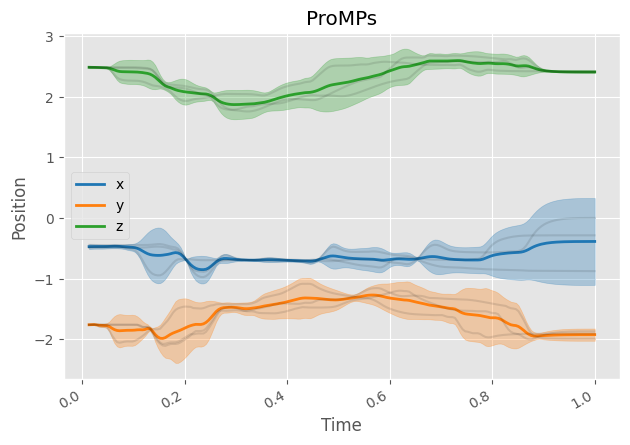

In [19]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    labels = ("x", "y", "z")
    for dim in range(Y_mean.shape[1]):
        label = labels[dim]
        ax.fill_between(
            T_smooth[0, :],
            (Y_mean[:, dim] - Y_conf[:, dim]).ravel(),
            (Y_mean[:, dim] + Y_conf[:, dim]).ravel(),
            alpha=0.3,
            color=cmap[dim],
        )
        ax.plot(T_smooth[0, :], Y_mean[:, dim], lw=2, label=label, color=cmap[dim])
        for d_i in range(num_demos):
            ax.plot(T_smooth[d_i, :], Y_smooth[d_i, :, dim + 1], c="k", alpha=0.1)

    ax.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("ProMPs")
    fig.tight_layout()
    fig.autofmt_xdate()
    plt.show()

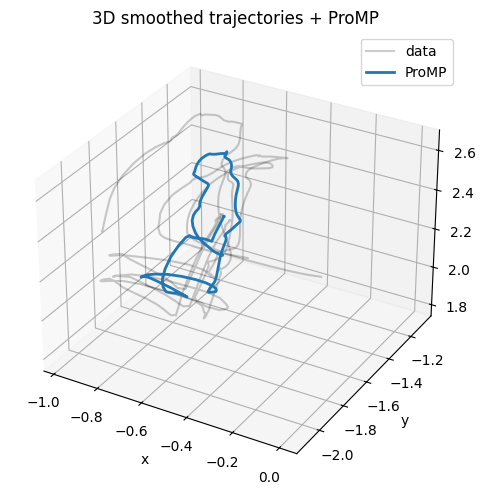

In [20]:
# with plt.style.context("ggplot"):
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
for d_i in range(num_demos):
    if d_i == 0:
        # ax.plot(df.x, df.y, df.z, c="k", alpha=0.2, label="data")
        ax.plot(
            Y_smooth[d_i, :, 1],
            Y_smooth[d_i, :, 2],
            Y_smooth[d_i, :, 3],
            label="data",
            alpha=0.2,
            c="k",
        )
    else:
        # ax.plot(df.x, df.y, df.z, c="k", alpha=0.2)
        ax.plot(
            Y_smooth[d_i, :, 1],
            Y_smooth[d_i, :, 2],
            Y_smooth[d_i, :, 3],
            alpha=0.2,
            c="k",
        )

ax.plot(Y_mean[:, 0], Y_mean[:, 1], Y_mean[:, 2], lw=2, label="ProMP")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
ax.set_title("3D smoothed trajectories + ProMP")
ax.legend(loc="best")
plt.show()

In [22]:
# genStates = np.zeros([timesteps, stateSize])
# genStates[:, :] = Y[0, :, :]

# genStates[:, 0] = T[0]
# genStates[:, 1:4] = Y_mean